In [1]:
import numpy as np
import astropy
from itertools import izip
from pearce.mocks import compute_prim_haloprop_bins, cat_dict
from pearce.mocks.customHODModels import *
from halotools.utils.table_utils import compute_conditional_percentiles
from halotools.mock_observables import hod_from_mock, wp, tpcf, tpcf_one_two_halo_decomp
from math import ceil

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [3]:
shuffle_type = ''#'sh_shuffled'
mag_type = 'vpeak'

In [4]:
mag_cut = -21
min_ptcl = 200
mag_key = 'halo_%s%s_mag'%(shuffle_type, mag_type)
upid_key = 'halo_%supid'%(shuffle_type)

In [5]:
PMASS = 591421440.0000001 #chinchilla 400/ 2048
catalog = astropy.table.Table.read('abmatched_halos.hdf5', format = 'hdf5')

In [6]:
cosmo_params = {'simname':'chinchilla', 'Lbox':400.0, 'scale_factors':[0.658, 1.0]}
cat = cat_dict[cosmo_params['simname']](**cosmo_params)#construct the specified catalog!

cat.load_catalog(1.0)
#cat.h = 1.0
halo_catalog = catalog[catalog['halo_mvir'] > min_ptcl*cat.pmass] #mass cut
galaxy_catalog = halo_catalog[ halo_catalog[mag_key] < mag_cut ] # mag cut

In [7]:
def compute_mass_bins(prim_haloprop, dlog10_prim_haloprop=0.05):   
    lg10_min_prim_haloprop = np.log10(np.min(prim_haloprop))-0.001
    lg10_max_prim_haloprop = np.log10(np.max(prim_haloprop))+0.001
    num_prim_haloprop_bins = (lg10_max_prim_haloprop-lg10_min_prim_haloprop)/dlog10_prim_haloprop
    return np.logspace(
        lg10_min_prim_haloprop, lg10_max_prim_haloprop,
        num=int(ceil(num_prim_haloprop_bins)))

In [8]:
mass_bins = compute_mass_bins(halo_catalog['halo_mvir'], 0.2)
mass_bin_centers = (mass_bins[1:]+mass_bins[:-1])/2.0

In [9]:
cen_mask = galaxy_catalog['halo_upid']==-1
cen_hod_sham, _ = hod_from_mock(galaxy_catalog[cen_mask]['halo_mvir_host_halo'],\
                        halo_catalog['halo_mvir'],\
                        mass_bins)

sat_hod_sham, _ = hod_from_mock(galaxy_catalog[~cen_mask]['halo_mvir_host_halo'],\
                        halo_catalog['halo_mvir'],\
                        mass_bins)

In [10]:
cat.load_model(1.0, HOD=(FSAssembiasTabulatedCens, FSAssembiasTabulatedSats), hod_kwargs = {'prim_haloprop_vals': mass_bin_centers,
                                                               #'sec_haloprop_key': 'halo_%s'%(mag_type),
                                                               'cen_hod_vals':cen_hod_sham,
                                                               'sat_hod_vals':sat_hod_sham,
                                                                'split':0.5})

In [11]:
print cat.model.param_dict

{'mean_occupation_satellites_assembias_split1': 0.5, 'mean_occupation_satellites_assembias_param1': 0.5, 'mean_occupation_centrals_assembias_split1': 0.5, 'mean_occupation_centrals_assembias_param1': 0.5}


In [12]:
#rp_bins = np.logspace(-1,1.5,20)
#rp_bins = np.logspace(-1.1,1.8, 25)
#rp_bins = np.loadtxt('/nfs/slac/g/ki/ki18/des/swmclau2/AB_tests/rp_bins.npy')
rp_bins = np.array([7.943282000000000120e-02,
1.122018500000000057e-01,
1.584893199999999891e-01,
2.238721100000000130e-01,
3.162277700000000191e-01,
4.466835900000000192e-01,
6.309573400000000332e-01,
8.912509400000000470e-01,
1.258925410000000022e+00,
1.778279409999999894e+00,
2.511886430000000114e+00,
3.548133889999999901e+00,
5.011872340000000037e+00,
7.079457839999999891e+00,
1.000000000000000000e+01,
1.412537544999999994e+01,
1.995262315000000086e+01,
2.818382931000000013e+01,
3.981071706000000177e+01])

bin_centers = (rp_bins[:1]+rp_bins[:-1])/2

In [13]:
min_logmass, max_logmass = 9.0, 17.0
names = ['mean_occupation_centrals_assembias_param1','mean_occupation_satellites_assembias_param1',\
        'mean_occupation_centrals_assembias_split1','mean_occupation_satellites_assembias_split1']

In [67]:
#mock_wp = cat.calc_wp(rp_bins, RSD= False)
MAP = np.array([ 1.0, -1.0,0.5,0.5])


params = dict(zip(names, MAP))
#print params.keys()

mock_wps = []
#mock_wps_1h, mock_wps_2h = [],[]
#mock_nds = []
split = np.linspace(0.1, 0.9, 4)
#split_abcissa = [10**9, 10**13, 10**16]

#cat.model._input_model_dictionary['centrals_occupation']._split_abscissa = split_abcissa
#cat.model._input_model_dictionary['satellites_occupation']._split_abscissa = split_abcissa
for p in split:
    params['mean_occupation_centrals_assembias_split1'] = p
    params['mean_occupation_satellites_assembias_split1'] = p
    #print params.keys()
    #print cat.model.param_dict
    cat.populate(params)
    #print cat.model.param_dict
    #cut_idx = cat.model.mock.galaxy_table['gal_type'] == 'centrals'
    mass_cut = np.logical_and(np.log10(cat.model.mock.galaxy_table['halo_mvir'] ) > min_logmass,\
                              np.log10(cat.model.mock.galaxy_table['halo_mvir'] ) <= max_logmass)
    #mass_cut = np.logical_and(mass_cut, cut_idx)
    #mock_nds.append(len(cut_idx)/cat.Lbox**3)
    mock_pos = np.c_[cat.model.mock.galaxy_table['x'],\
                     cat.model.mock.galaxy_table['y'],\
                     cat.model.mock.galaxy_table['z']]
    mock_wps.append(wp(mock_pos*cat.h, rp_bins ,40.0*cat.h,  period=cat.Lbox*cat.h, num_threads=1))
    #oneh, twoh = tpcf_one_two_halo_decomp(mock_pos,cat.model.mock.galaxy_table[mass_cut]['halo_hostid'],\
    #                                      rp_bins , period=cat.Lbox, num_threads=1)
    #mock_wps_1h.append(oneh)
    #mock_wps_2h.append(twoh)
    
mock_wps = np.array(mock_wps)
wp_errs = np.std(mock_wps, axis = 0)

#mock_wps_1h = np.array(mock_wps_1h)
#mock_wp_no_ab_1h = np.mean(mock_wps_1h, axis = 0)

#mock_wps_2h = np.array(mock_wps_2h)
#mock_wp_no_ab_2h = np.mean(mock_wps_2h, axis = 0)

#mock_nds = np.array(mock_nds)
#mock_nd = np.mean(mock_nds)
#nd_err = np.std(mock_nds)

In [68]:
params = dict(zip(names, [0.0,0.0, 0.5,0.5]))   
cat.populate(params)
mass_cut = np.logical_and(np.log10(cat.model.mock.galaxy_table['halo_mvir'] ) > min_logmass,\
                          np.log10(cat.model.mock.galaxy_table['halo_mvir'] ) <= max_logmass)

print cat.model.param_dict
mock_pos = np.c_[cat.model.mock.galaxy_table['x'],\
                 cat.model.mock.galaxy_table['y'],\
                 cat.model.mock.galaxy_table['z']]
noab_wp = wp(mock_pos*cat.h, rp_bins ,40.0*cat.h, period=cat.Lbox*cat.h, num_threads=1)

{'mean_occupation_centrals_assembias_split1': 0.5, 'mean_occupation_centrals_assembias_param1': 0.0, 'mean_occupation_satellites_assembias_split1': 0.5, 'mean_occupation_satellites_assembias_param1': 0.0}


In [69]:
print noab_wp

[ 714.37008428  515.58287946  350.075667    230.07802999  154.94007458
  109.11784338   77.90006422   56.91434485   42.76340462   33.31347123
   26.33903358   20.0577697    14.38994432   10.23101709    6.87005617
    3.77454345    1.90646581    0.74010344]


In [70]:
from halotools.mock_observables import return_xyz_formatted_array

In [71]:
sham_pos = np.c_[galaxy_catalog['halo_x'],\
                 galaxy_catalog['halo_y'],\
                 galaxy_catalog['halo_z']]

distortion_dim = 'z'
v_distortion_dim = galaxy_catalog['halo_v%s' % distortion_dim]
# apply redshift space distortions
#sham_pos = return_xyz_formatted_array(sham_pos[:,0],sham_pos[:,1],sham_pos[:,2],  velocity=v_distortion_dim, \
#                                 velocity_distortion_dimension=distortion_dim, period=cat.Lbox)
#sham_wp = wp(sham_pos*cat.h, rp_bins, 40.0*cat.h, period=cat.Lbox*cat.h, num_threads=1)
sham_wp = wp(sham_pos*cat.h, rp_bins, 40.0*cat.h, period=cat.Lbox*cat.h, num_threads=1)

#sham_wp = tpcf(sham_pos, rp_bins , period=cat.Lbox, num_threads=1)

In [72]:
sham_wp

array([ 584.13088582,  446.77230202,  352.39713097,  233.66110444,
        170.22857317,  116.8310956 ,   86.1341947 ,   63.34798862,
         47.95916411,   36.86749563,   28.27748673,   20.94600314,
         15.09222186,   10.6114766 ,    6.99502884,    4.19488178,
          2.07652477,    0.73773839])

In [73]:
len(galaxy_catalog)/((cat.Lbox*cat.h)**3)

0.002723305393586006

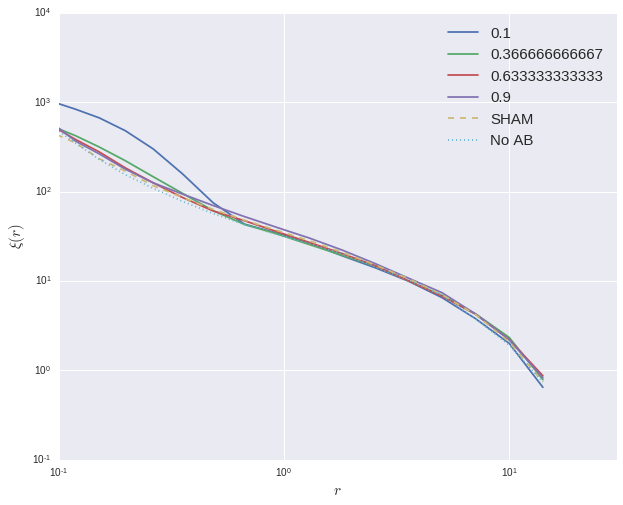

In [74]:
plt.figure(figsize=(10,8))
for p, mock_wp in zip(split, mock_wps):
    plt.plot(bin_centers, mock_wp, label = p)
    
plt.plot(bin_centers, sham_wp, ls='--', label = 'SHAM')
plt.plot(bin_centers, noab_wp, ls=':', label = 'No AB')


plt.loglog()
plt.legend(loc='best',fontsize = 15)
plt.xlim([1e-1, 30e0]);
#plt.ylim([1,15000])
plt.xlabel(r'$r$',fontsize = 15)
plt.ylabel(r'$\xi(r)$',fontsize = 15)
plt.show()

In [75]:
print sham_wp

[ 584.13088582  446.77230202  352.39713097  233.66110444  170.22857317
  116.8310956    86.1341947    63.34798862   47.95916411   36.86749563
   28.27748673   20.94600314   15.09222186   10.6114766     6.99502884
    4.19488178    2.07652477    0.73773839]


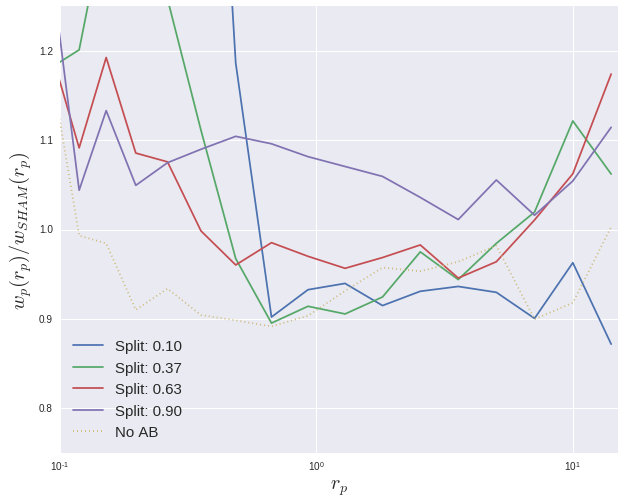

In [77]:
plt.figure(figsize=(10,8))
split = np.linspace(0.1, 0.9, 4)

for p, mock_wp in zip(split, mock_wps):
    plt.plot(bin_centers, mock_wp/sham_wp, label = 'Split: %0.2f'%p)
    
#plt.plot(bin_centers, sham_wp, ls='--', label = 'SHAM')
plt.plot(bin_centers, noab_wp/sham_wp, ls=':', label = 'No AB')


#plt.loglog()
plt.xscale('log')
plt.legend(loc='best',fontsize = 15)
plt.xlim([1e-1, 15e0]);
plt.ylim([0.75,1.25])
plt.xlabel(r'$r_p$',fontsize = 20)
plt.ylabel(r'$w_p(r_p)/w_{SHAM}(r_p)$',fontsize = 20)
plt.show()

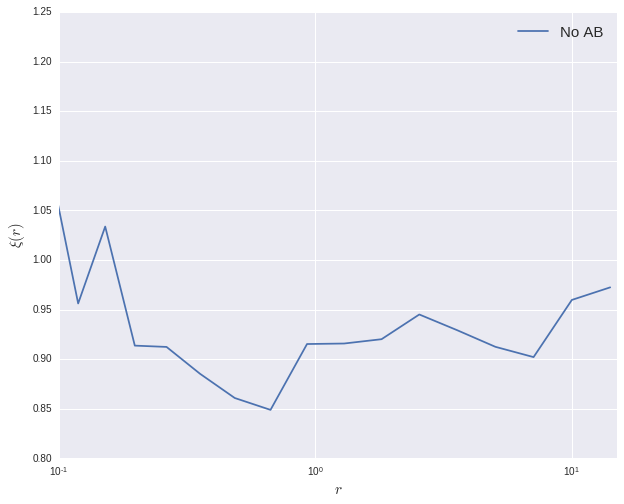

In [24]:
plt.figure(figsize=(10,8))
#for p, mock_wp in zip(split, mock_wps):
#    plt.plot(bin_centers, mock_wp/sham_wp, label = p)
    
#plt.plot(bin_centers, sham_wp, ls='--', label = 'SHAM')
plt.plot(bin_centers, noab_wp/sham_wp, label = 'No AB')


#plt.loglog()
plt.xscale('log')
plt.legend(loc='best',fontsize = 15)
plt.xlim([1e-1, 15e0]);
#plt.ylim([1,15000])
plt.xlabel(r'$r$',fontsize = 15)
plt.ylabel(r'$\xi(r)$',fontsize = 15)
plt.show()

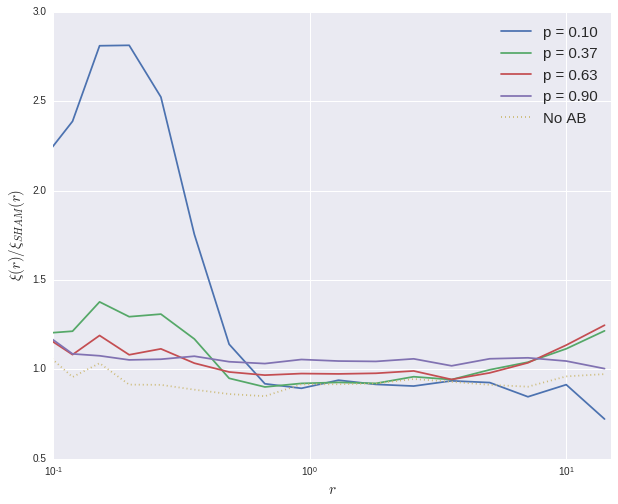

In [25]:
plt.figure(figsize=(10,8))
#avg = mock_wps.mean(axis = 0)
for p, mock_wp in zip(split, mock_wps):
    plt.plot(bin_centers, mock_wp/sham_wp, label = 'p = %.2f'%p)
    #pass
    
plt.plot(bin_centers, noab_wp/sham_wp, label = 'No AB', ls = ':')

#plt.loglog()
plt.xscale('log')
plt.legend(loc='best',fontsize = 15)
plt.xlim([1e-1, 15e0]);
#plt.ylim([0.75,1.25]);
plt.xlabel(r'$r$',fontsize = 15)
plt.ylabel(r'$\xi(r)/\xi_{SHAM}(r)$',fontsize = 15)
plt.show()

In [26]:
noab_wp

array([ 704.74196371,  480.60824591,  336.99230405,  241.56244833,
        155.55373584,  106.60601069,   76.26673002,   54.54202185,
         40.71791375,   33.74856826,   25.89952821,   19.27577625,
         14.26481684,    9.86121666,    6.38360869,    3.78468509,
          1.99315105,    0.71746894])

In [27]:
sham_wp

array([ 584.13088582,  446.77230202,  352.39713097,  233.66110444,
        170.22857317,  116.8310956 ,   86.1341947 ,   63.34798862,
         47.95916411,   36.86749563,   28.27748673,   20.94600314,
         15.09222186,   10.6114766 ,    6.99502884,    4.19488178,
          2.07652477,    0.73773839])

In [28]:
sats_occ = cat.model._input_model_dictionary['satellites_occupation']
sats_occ._split_ordinates = [0.99]

In [29]:
print sats_occ

In [30]:
baseline_lower_bound, baseline_upper_bound = 0,np.inf
prim_haloprop = cat.model.mock.halo_table['halo_mvir']
sec_haloprop = cat.model.mock.halo_table['halo_nfw_conc']

In [31]:
from halotools.utils.table_utils import compute_conditional_percentile_values

In [32]:
split = sats_occ.percentile_splitting_function(prim_haloprop)

# Compute the baseline, undecorated result
result = sats_occ.baseline_mean_occupation(prim_haloprop=prim_haloprop)

# We will only decorate values that are not edge cases,
# so first compute the mask for non-edge cases
no_edge_mask = (
    (split > 0) & (split < 1) &
    (result > baseline_lower_bound) & (result < baseline_upper_bound)
)
# Now create convenient references to the non-edge-case sub-arrays
no_edge_result = result[no_edge_mask]
no_edge_split = split[no_edge_mask]

In [33]:
from halotools.utils.table_utils import compute_conditional_averages

In [34]:
strength = sats_occ.assembias_strength(prim_haloprop[no_edge_mask])
slope = sats_occ.assembias_slope(prim_haloprop[no_edge_mask])

# the average displacement acts as a normalization we need.
max_displacement = sats_occ._disp_func(sec_haloprop=pv_sub_sec_haloprop/np.max(np.abs(pv_sub_sec_haloprop)), slope=slope)
disp_average = compute_conditional_averages(vals=max_displacement,prim_haloprop=prim_haloprop[no_edge_mask])
#disp_average = np.ones((prim_haloprop.shape[0], ))*0.5

perturbation2 = np.zeros(len(prim_haloprop[no_edge_mask]))

greater_than_half_avg_idx = disp_average > 0.5
less_than_half_avg_idx = disp_average <= 0.5

if len(max_displacement[greater_than_half_avg_idx]) > 0:
    base_pos = result[no_edge_mask][greater_than_half_avg_idx]
    strength_pos = strength[greater_than_half_avg_idx]
    avg_pos = disp_average[greater_than_half_avg_idx]

    upper_bound1 = (base_pos - baseline_lower_bound)/avg_pos
    upper_bound2 = (baseline_upper_bound - base_pos)/(1-avg_pos)
    upper_bound = np.minimum(upper_bound1, upper_bound2)
    print upper_bound1, upper_bound2
    perturbation2[greater_than_half_avg_idx] = strength_pos*upper_bound*(max_displacement[greater_than_half_avg_idx]-avg_pos)
    

if len(max_displacement[less_than_half_avg_idx]) > 0:
    base_neg = result[no_edge_mask][less_than_half_avg_idx]
    strength_neg = strength[less_than_half_avg_idx]
    avg_neg = disp_average[less_than_half_avg_idx]

    lower_bound1 = (base_neg-baseline_lower_bound)/avg_neg#/(1- avg_neg)
    lower_bound2 = (baseline_upper_bound - base_neg)/(1-avg_neg)#(avg_neg)
    lower_bound = np.minimum(lower_bound1, lower_bound2)
    perturbation2[less_than_half_avg_idx] = strength_neg*lower_bound*(max_displacement[less_than_half_avg_idx]-avg_neg)



AttributeError: 'FSAssembiasTabulatedSats' object has no attribute 'assembias_slope'

In [ ]:
print np.unique(max_displacement[indices_of_mb])
print np.unique(disp_average[indices_of_mb])

In [ ]:
perturbation

In [ ]:
mass_bins = compute_mass_bins(prim_haloprop)
mass_bin_idxs = compute_prim_haloprop_bins(prim_haloprop_bin_boundaries=mass_bins, prim_haloprop = prim_haloprop[no_edge_mask])
mb = 87
indices_of_mb = np.where(mass_bin_idxs == mb)[0]

In [ ]:
plt.hist(perturbation[indices_of_mb], bins =100);
plt.yscale('log');
#plt.loglog();

In [ ]:
print max(perturbation)
print min(perturbation)

In [ ]:
print max(perturbation[indices_of_mb])
print min(perturbation[indices_of_mb])

In [ ]:
idxs = np.argsort(perturbation)
print mass_bin_idxs[idxs[-10:]]

In [ ]:
plt.hist(perturbation2[indices_of_mb], bins =100);
plt.yscale('log');
#plt.loglog();

In [ ]:
print perturbation2